In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Fri Dec 16 21:57:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    55W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import time
import h5py
import matplotlib.pyplot as plt
import os
import sys
import scipy
import cv2
import random
from PIL import Image
from scipy import ndimage
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import *

In [3]:
import pandas as pd
from keras.applications.vgg16 import VGG16
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

from tensorflow import keras
from keras import layers
from keras.utils import load_img
from keras.utils import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout
from keras.models import Sequential
import tensorflow as tf

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip /content/drive/MyDrive/state-farm-distracted-driver-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: state-farm-distracted-driver-detection/imgs/train/c7/img_56717.jpg  
  inflating: state-farm-distracted-driver-detection/imgs/train/c7/img_56724.jpg  
  inflating: state-farm-distracted-driver-detection/imgs/train/c7/img_56768.jpg  
  inflating: state-farm-distracted-driver-detection/imgs/train/c7/img_56779.jpg  
  inflating: state-farm-distracted-driver-detection/imgs/train/c7/img_56849.jpg  
  inflating: state-farm-distracted-driver-detection/imgs/train/c7/img_56899.jpg  
  inflating: state-farm-distracted-driver-detection/imgs/train/c7/img_56938.jpg  
  inflating: state-farm-distracted-driver-detection/imgs/train/c7/img_5706.jpg  
  inflating: state-farm-distracted-driver-detection/imgs/train/c7/img_57076.jpg  
  inflating: state-farm-distracted-driver-detection/imgs/train/c7/img_57122.jpg  
  inflating: state-farm-distracted-driver-detection/imgs/train/c7/img_57137.jpg  
  inflating: state-farm-distracted-driver-detect

In [6]:

import time
import h5py
import matplotlib.pyplot as plt
import os
import sys
import scipy
import random

In [7]:
df = pd.read_csv('/content/state-farm-distracted-driver-detection/driver_imgs_list.csv')
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [8]:
unique_drivers = df.groupby('subject').groups.keys()
print(unique_drivers)

dict_keys(['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081'])


In [9]:
print(os.getcwd())


/content


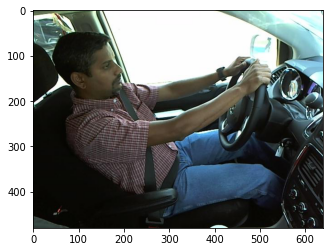

In [10]:
from numpy.ma.core import expand_dims
image = load_img("/content/state-farm-distracted-driver-detection/imgs/train/c0/img_34.jpg")
plt.imshow(image)
plt.show()
image = img_to_array(image)
image = expand_dims(image, 0)

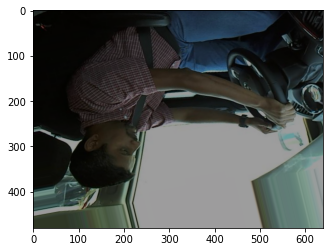

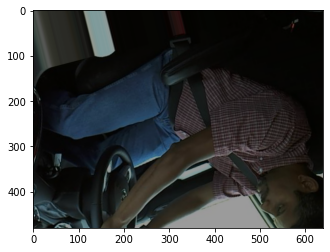

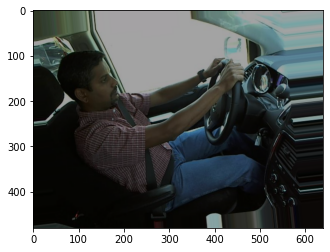

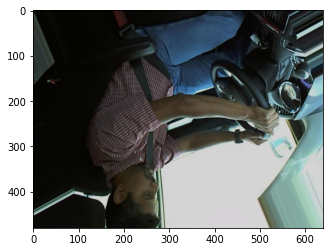

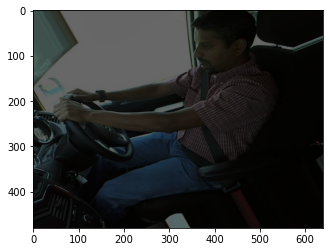

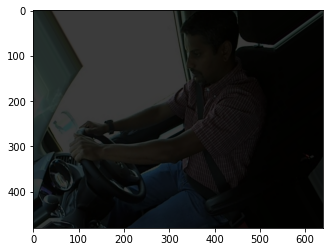

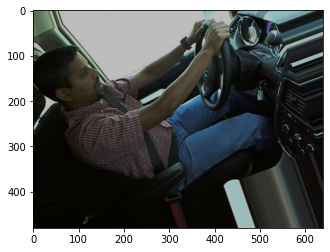

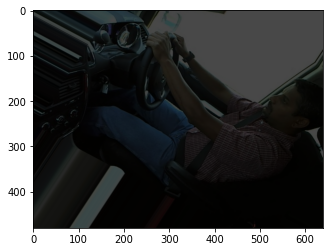

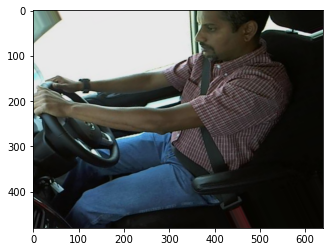

In [11]:
generator = ImageDataGenerator(rotation_range=40, zoom_range = 0.2, horizontal_flip = True, vertical_flip = True, fill_mode = "nearest", shear_range=0.2, width_shift_range = 0.1, brightness_range = [0.2, 1.0])

iterator = generator.flow(image,batch_size = 1)

for i in range(9):
    batch = iterator.next()
    new_image = batch[0].astype("uint8")
    plt.imshow(new_image)
    plt.show()


In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/state-farm-distracted-driver-detection/imgs/train",
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=(224, 224),
    label_mode = "categorical",
    batch_size=200)

Found 22424 files belonging to 10 classes.
Using 15697 files for training.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/state-farm-distracted-driver-detection/imgs/train",
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    label_mode = "categorical",
    batch_size=200)

Found 22424 files belonging to 10 classes.
Using 6727 files for validation.


In [14]:
class_names = train_ds.class_names
print(class_names)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


In [15]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomContrast(0.2),
  layers.RandomTranslation(0.2,0.2)
])

In [16]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# ## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False ## Not trainable weights

58889256/58889256 [==============================] - 0s 0us/step


In [17]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False
pretrained_model.layers.pop()
pretrained_model.layers.pop()
pretrained_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

In [18]:
from pandas.core.groupby import base
model= Sequential([
    layers.Rescaling(1./255, input_shape=(224,224,3)),
    pretrained_model,
    # layers.Rescaling(1./255, input_shape=(180, 180, 3)), # normalization (n, m, 3)
    # layers.Conv2D(filters=32,kernel_size = (3,3),  activation='relu'),
    # layers.MaxPool2D(2,2),
    # layers.Conv2D(filters=32,kernel_size = (3,3),  activation='relu'),
    # layers.MaxPool2D(2,2),
    # layers.Conv2D(filters=32,kernel_size = (3,3),  activation='relu'),
    # layers.MaxPool2D(2,2),
    # layers.Conv2D(filters=32,kernel_size = (3,3),  activation='relu'),
    # layers.MaxPooling2D(),
    layers.Flatten(),

    layers.Dense(512,activation='relu'),
    layers.Dense(512,activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(10,activation = 'softmax') ## [0,1. 0.03, 0.21, 0.11]


])

model.compile(
    loss='categorical_crossentropy',
    metrics=['acc'],
    optimizer='adam'
)

In [19]:
model.build()

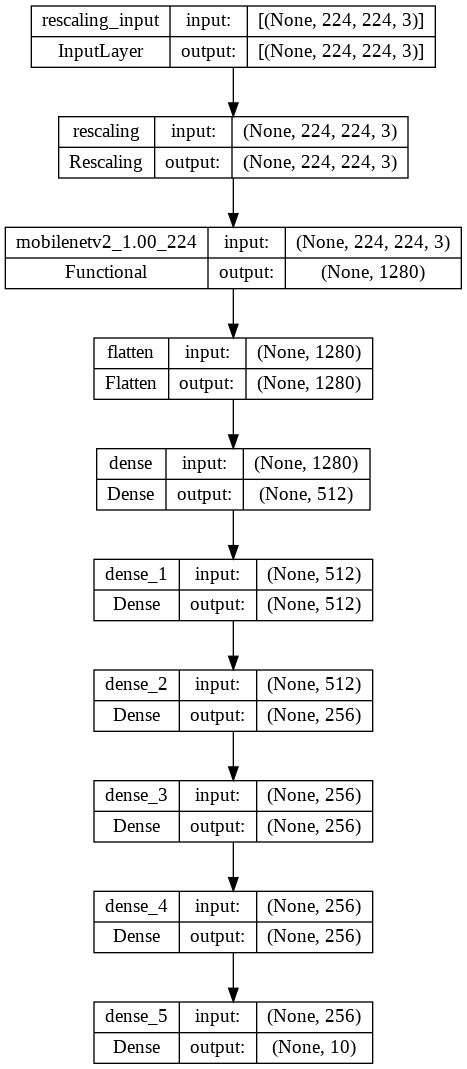

In [20]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)


In [21]:
history = model.fit(train_ds, epochs = 10, validation_data = val_ds)


Epoch 1/10
79/79 [==============================] - 23s 148ms/step - loss: 1.0232 - acc: 0.6459 - val_loss: 0.3856 - val_acc: 0.8722
Epoch 2/10
79/79 [==============================] - 11s 129ms/step - loss: 0.2509 - acc: 0.9205 - val_loss: 0.1914 - val_acc: 0.9443
Epoch 3/10
79/79 [==============================] - 11s 127ms/step - loss: 0.1112 - acc: 0.9669 - val_loss: 0.1278 - val_acc: 0.9600
Epoch 4/10
79/79 [==============================] - 11s 128ms/step - loss: 0.0585 - acc: 0.9822 - val_loss: 0.1215 - val_acc: 0.9636
Epoch 5/10
79/79 [==============================] - 11s 128ms/step - loss: 0.0604 - acc: 0.9801 - val_loss: 0.0731 - val_acc: 0.9783
Epoch 6/10
79/79 [==============================] - 11s 129ms/step - loss: 0.0490 - acc: 0.9850 - val_loss: 0.1050 - val_acc: 0.9706
Epoch 7/10
79/79 [==============================] - 11s 127ms/step - loss: 0.0337 - acc: 0.9887 - val_loss: 0.0860 - val_acc: 0.9752
Epoch 8/10
79/79 [==============================] - 11s 128ms/step - 

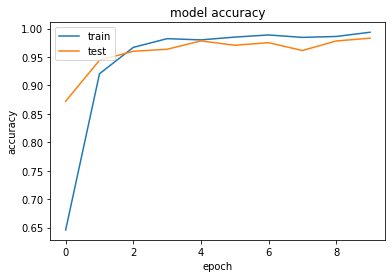

In [22]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

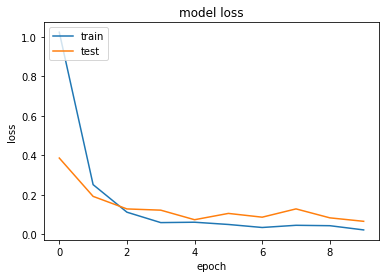

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
# Evaluating model on validation data
# loss and accuracy
evaluate_train = model.evaluate(train_ds)
print(evaluate_train)
evaluate_val = model.evaluate(val_ds)
print(evaluate_val)

79/79 [==============================] - 7s 84ms/step - loss: 0.0084 - acc: 0.9973
[0.00837232731282711, 0.9973243474960327]
34/34 [==============================] - 3s 86ms/step - loss: 0.0650 - acc: 0.9831
[0.0650060698390007, 0.9830533862113953]
